In [1]:
par_log_transform = True

In [2]:
import numpy as np

import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.stats import binom, poisson, norm
from scipy.special import comb     
from matplotlib import rc 
import seaborn as sns 
rc('text', usetex=True)

In [3]:
with np.load('fsp_solutions.npz', allow_pickle=True) as fsp_sol_file:
    rna_distributions = fsp_sol_file['rna_distributions']
    rna_sensitivities = fsp_sol_file['rna_sensitivities']
    t_meas = fsp_sol_file['t_meas']

with np.load('fim_flowcyt.npz', allow_pickle=True) as f:
    flowcyt_prob = f['flowcyt_prob']
    
with np.load('flowcyt_pars.npz') as f:
    kappa=f['kappa']
    sigma_probe=f['sigma_probe']
    mu_bg=f['mu_bg']
    sigma_bg=f['sigma_bg']

with np.load('bursting_parameters.npz') as par:
    k_on = par['kon']
    k_off = par['koff']
    k_r = par['kr']
    gamma = par['gamma']

theta = np.array([k_on, k_off, k_r, gamma])

## Modeling measurement noise with binomial distribution

In [4]:
p_success = 0.5
def BinomialNoiseMatrix(n_max, p_success):
    M = np.zeros((n_max + 1, n_max + 1))  
    for j in range(0, n_max + 1):
            M[:, j] = binom.pmf(np.linspace(0, n_max, n_max+1), j, p_success) 
    return M

n_max = 400
C_binom = BinomialNoiseMatrix(n_max, p_success)

In [5]:
with np.load('fim_exact.npz') as data:
    fim_exact = data['fim_exact']

with np.load('fim_binom.npz') as data:
    fim_binom = data['fim_binom']        

with np.load('fim_flowcyt.npz') as data:
    fim_flowcyt = data['fim_flowcyt']

if par_log_transform:
    for it in range(0, len(t_meas)):
        for i in range(0,4):
            for j in range(0,4):
                fim_exact[it, i, j] *= theta[i]*theta[j]*np.log(10)*np.log(10)
                fim_binom[it, i, j] *= theta[i]*theta[j]*np.log(10)*np.log(10)
                fim_flowcyt[it, i, j] *= theta[i]*theta[j]*np.log(10)*np.log(10)

def plot_conf_ellipse(fim, num_sigma, ax, par_idx, color='red', label='my_ellipse'):
    covmat = np.linalg.inv(fim)
    [eigvals, eigvecs] = np.linalg.eig(covmat[np.ix_([par_idx[0],par_idx[1]], [par_idx[0],par_idx[1]])])
    
    indx = np.argsort(eigvals)
    indx = np.flip(indx)
    eigvals = eigvals[indx]
    eigvecs = eigvecs[:,indx]
            
    mu0 = np.log10(theta[par_idx[0]])
    mu1 = np.log10(theta[par_idx[1]])
    sigma0 = np.sqrt(eigvals[0])
    sigma1 = np.sqrt(eigvals[1])
    a = num_sigma*sigma0
    b = num_sigma*sigma1

    ax.axvline(mu0, color='k', linestyle='-', alpha=0.1)
    ax.axhline(mu1, color='k', linestyle='-', alpha=0.1)
    
    phi = np.arctan2(eigvecs[1,0],eigvecs[0,0])
    if phi < 0:
        phi = phi + 2*np.pi 

    rot_matrix = np.array([
                            [np.cos(phi), -np.sin(phi)],
                            [np.sin(phi), np.cos(phi)]
                           ])
    
    phi_grid = np.linspace(0, 2*np.pi, 100)
    ellipse_x_r = a*np.cos(phi_grid)
    ellipse_y_r = b*np.sin(phi_grid)
    
    r_ellipse = np.array(rot_matrix@[ellipse_x_r, ellipse_y_r])
    
    ax.plot(r_ellipse[0,:] + mu0, r_ellipse[1,:] + mu1, color=color, label=label)
        
    # Plot the major ax           
    ax.plot([mu0 - eigvecs[0,0]*a, mu0 + eigvecs[0,0]*a], [mu1 - eigvecs[1,0]*a, mu1 + eigvecs[1,0]*a], color=color, 
            linestyle='--')
    
    return 0

In [6]:
num_pixels = 100 # number of pixels occupied by a typical cells
def LowResNoiseMatrix(n_max):
    M = np.zeros((n_max + 1, n_max + 1))  
    M[0,0] = 1.0
    for j in range(1, n_max + 1):
            M[:, j] = comb(num_pixels, np.arange(0, n_max+1))*comb(j-1, np.arange(0,n_max+1)-1)/comb(num_pixels + j - 1, j)       
    return M

n_max = 400
C_lowres = LowResNoiseMatrix(n_max)

fim_lowres = np.zeros((len(t_meas), 4, 4))
for itime in range(0, len(t_meas)):
    M = np.zeros((4,4))
    xmax = len(rna_distributions[itime])-1
    p = C_lowres[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    for ip in range(0, 4):
        sip = C_lowres[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][ip]
        for jp in range(0, ip+1):
            sjp = C_lowres[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][jp]
            M[ip, jp] = np.sum(sip*sjp/np.maximum(1.e-16, p))
    for ip in range(0,4):
        for jp in range(ip+1,4):
            M[ip, jp] = M[jp, ip]
    fim_lowres[itime, :, :] = M

In [7]:
t_idx_to_plot = 300

def plot_rna_dist_sens(itime):
    fig_smfish = plt.figure()
    fig_smfish.set_tight_layout(True)
    fig_smfish.set_size_inches(3,3)
    
    
    fig_smfish.legend(bbox_to_anchor=(0,1,1.5,1.5), loc="lower left")
    
    return fig_smfish
    
fig_smfish = plot_rna_dist_sens(t_idx_to_plot)
fig_smfish.savefig('abstract_distributions.pdf', bbox_inches='tight')


No handles with labels found to put in legend.


<Figure size 216x216 with 0 Axes>

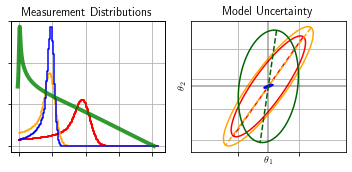

In [17]:
t_idx_to_plot = 100
design_colors = ['red', 'orange', 'blue', 'darkgreen', 'magenta']

design_labels = [f'Exact measurement', 
                f'Missing spots',
                f'Low-resolution Imaging',                
                f'Flow cytometry',                
                 ]

fim_mats = [1000*fim_exact[t_idx_to_plot, :, :], 
            1000*fim_binom[t_idx_to_plot, :, :], 
            1000*fim_lowres[t_idx_to_plot, :, :],            
            10000*fim_flowcyt[t_idx_to_plot, :, :],
            ]

fig, axs = plt.subplots(1,2)
fig.set_tight_layout(True)
fig.set_size_inches(5, 2.5)

xmax = len(rna_distributions[itime])-1
p_binom = C_binom[0:xmax+1, 0:xmax+1]@rna_distributions[itime]    
p_lowres = C_lowres[0:xmax+1, 0:xmax+1]@rna_distributions[itime]


axs[0].step(np.arange(0, xmax+1), rna_distributions[itime], label='True sample', color='red', linewidth=2)    
axs[0].step(np.arange(0, xmax+1), p_binom, color='orange', linestyle='-', label='Missing spots')
axs[0].step(np.arange(0, xmax+1), p_lowres, color='blue', linestyle='-', label='Low-resolution Imaging')

# axs[0].set_xlabel('RNA molecule count/Fluorescence Intensity')
# axs[0].set_ylabel(r'\textbf{Probability}')
axs[0].tick_params(axis='y', labelcolor='green', which='both', left=False, right=False, labelleft=False)
axs[0].tick_params(axis='x', which='both', labelbottom=False)

ax1 = axs[0].twinx()    
ax1.plot(flowcyt_prob[itime]['yeval']/kappa, flowcyt_prob[itime]['peval'], 
        color='green', linestyle='-', linewidth=4, alpha=0.8, label='Flow cytometry')
ax1.tick_params(axis='y', labelcolor='green', which='both', left=False, right=False, labelright=False)

axs[0].grid()
axs[0].set_title('Measurement Distributions')    

# The 3-sigma ellipses of different experiments
for i in range(0, len(fim_mats)):
# for i in [0]:
    plot_conf_ellipse(fim_mats[i], 3, axs[1], [0,1], design_colors[i], design_labels[i])

axs[1].set_xlabel(r'$\theta_1$')    
axs[1].set_ylabel(r'$\theta_2$')
axs[1].tick_params(axis='y', labelcolor='green', which='both', left=False, right=False, labelleft=False)
axs[1].tick_params(axis='x', which='both', labelbottom=False)

axs[1].autoscale()
axs[1].set_aspect('equal', adjustable='datalim')
axs[1].grid()
axs[1].set_title('Model Uncertainty')

h, l = axs[0].get_legend_handles_labels()
# fig.legend(h, l, bbox_to_anchor=(0.1, 1.0, 0.1, 1.1), loc='lower left', ncol=1)
plt.show()
fig.savefig('abstract_plots.pdf', bbox_inches='tight')